In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 

data = pd.read_csv("TSLA.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3359,2023-11-01,204.039993,205.990005,197.850006,205.660004,205.660004,121661700
3360,2023-11-02,212.970001,219.199997,211.449997,218.509995,218.509995,125987600
3361,2023-11-03,221.149994,226.369995,218.399994,219.960007,219.960007,119281000
3362,2023-11-06,223.979996,226.320007,215.000000,219.270004,219.270004,117335800


In [2]:
data = data[["Date", "Close"]]
data

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3359,2023-11-01,205.660004
3360,2023-11-02,218.509995
3361,2023-11-03,219.960007
3362,2023-11-06,219.270004


In [3]:
# this allows us to enable gpu if we have gpu
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

/var/folders/98/6x2vtmsd3mq4_ylswvznj38r0000gn/T/ipykernel_13246/1781244370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = pd.to_datetime(data["Date"])


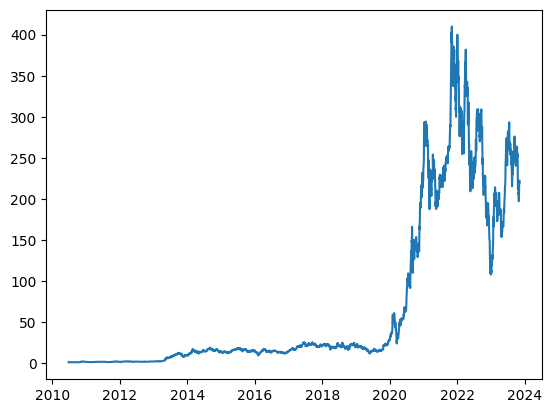

In [4]:
data["Date"] = pd.to_datetime(data["Date"])
plt.plot(data["Date"], data["Close"])

In [5]:
from copy import deepcopy as dc 

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index("Date", inplace=True)

    for i in range(1, n_steps+1):
        df[f"Close(t-{i})"] = df["Close"].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2010-07-09,1.160000,1.164000,1.053333,1.074000,1.280000,1.464000,1.588667,1.592667
2010-07-12,1.136667,1.160000,1.164000,1.053333,1.074000,1.280000,1.464000,1.588667
2010-07-13,1.209333,1.136667,1.160000,1.164000,1.053333,1.074000,1.280000,1.464000
2010-07-14,1.322667,1.209333,1.136667,1.160000,1.164000,1.053333,1.074000,1.280000
2010-07-15,1.326000,1.322667,1.209333,1.136667,1.160000,1.164000,1.053333,1.074000
...,...,...,...,...,...,...,...,...
2023-11-01,205.660004,200.839996,197.360001,207.300003,205.759995,212.419998,216.520004,212.080002
2023-11-02,218.509995,205.660004,200.839996,197.360001,207.300003,205.759995,212.419998,216.520004
2023-11-03,219.960007,218.509995,205.660004,200.839996,197.360001,207.300003,205.759995,212.419998


In [6]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[  1.15999997,   1.16400003,   1.05333304, ...,   1.46399999,
          1.58866704,   1.59266698],
       [  1.13666701,   1.15999997,   1.16400003, ...,   1.27999997,
          1.46399999,   1.58866704],
       [  1.20933294,   1.13666701,   1.15999997, ...,   1.074     ,
          1.27999997,   1.46399999],
       ...,
       [219.96000671, 218.50999451, 205.66000366, ..., 207.30000305,
        205.75999451, 212.41999817],
       [219.27000427, 219.96000671, 218.50999451, ..., 197.36000061,
        207.30000305, 205.75999451],
       [222.17999268, 219.27000427, 219.96000671, ..., 200.83999634,
        197.36000061, 207.30000305]])

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-9.99885856e-01, -9.99866288e-01, -1.00000000e+00, ...,
        -9.97991439e-01, -9.97381696e-01, -9.97362133e-01],
       [-1.00000000e+00, -9.99885856e-01, -9.99458731e-01, ...,
        -9.98891378e-01, -9.97991439e-01, -9.97381696e-01],
       [-9.99644521e-01, -1.00000000e+00, -9.99478295e-01, ...,
        -9.99898918e-01, -9.98891378e-01, -9.97991439e-01],
       ...,
       [ 7.04769958e-02,  6.33835811e-02,  7.25509823e-04, ...,
         8.74670102e-03,  1.21456225e-03,  3.37884541e-02],
       [ 6.71015253e-02,  7.04769958e-02,  6.35744560e-02, ...,
        -3.98695732e-02,  8.74670102e-03,  1.21456225e-03],
       [ 8.13370984e-02,  6.71015253e-02,  7.06664252e-02, ...,
        -2.28490113e-02, -3.98695732e-02,  8.74670102e-03]])

In [8]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3357, 7), (3357,))

In [9]:
X = dc(np.flip(X, axis=1))
X

array([[-9.97362133e-01, -9.97381696e-01, -9.97991439e-01, ...,
        -9.99898918e-01, -1.00000000e+00, -9.99866288e-01],
       [-9.97381696e-01, -9.97991439e-01, -9.98891378e-01, ...,
        -1.00000000e+00, -9.99458731e-01, -9.99885856e-01],
       [-9.97991439e-01, -9.98891378e-01, -9.99898918e-01, ...,
        -9.99458731e-01, -9.99478295e-01, -1.00000000e+00],
       ...,
       [ 3.37884541e-02,  1.21456225e-03,  8.74670102e-03, ...,
        -2.28490113e-02,  7.25509823e-04,  6.33835811e-02],
       [ 1.21456225e-03,  8.74670102e-03, -3.98695732e-02, ...,
         7.25509823e-04,  6.35744560e-02,  7.04769958e-02],
       [ 8.74670102e-03, -3.98695732e-02, -2.28490113e-02, ...,
         6.35744560e-02,  7.06664252e-02,  6.71015253e-02]])

In [10]:
split_index = int(len(X)*0.95)
split_index

3189

In [11]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3189, 7), (168, 7), (3189,), (168,))

In [12]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3189, 7, 1), (168, 7, 1), (3189, 1), (168, 1))

In [13]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3189, 7, 1]),
 torch.Size([168, 7, 1]),
 torch.Size([3189, 1]),
 torch.Size([168, 1]))

In [14]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
train_dataset

In [16]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out 
    
model = LSTM(1, 4, 1)
model.to(device)
model


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [20]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [21]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.208
Batch 200, Loss: 0.684

Val Loss: 0.154
***************************************************

Epoch: 2
Batch 100, Loss: 0.167
Batch 200, Loss: 0.036

Val Loss: 0.033
***************************************************

Epoch: 3
Batch 100, Loss: 0.016
Batch 200, Loss: 0.011

Val Loss: 0.013
***************************************************

Epoch: 4
Batch 100, Loss: 0.009
Batch 200, Loss: 0.008

Val Loss: 0.010
***************************************************

Epoch: 5
Batch 100, Loss: 0.007
Batch 200, Loss: 0.006

Val Loss: 0.006
***************************************************

Epoch: 6
Batch 100, Loss: 0.005
Batch 200, Loss: 0.004

Val Loss: 0.006
***************************************************

Epoch: 7
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003

Val Loss: 0.004
***************************************************

Epoch: 8
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.004
***************************************************



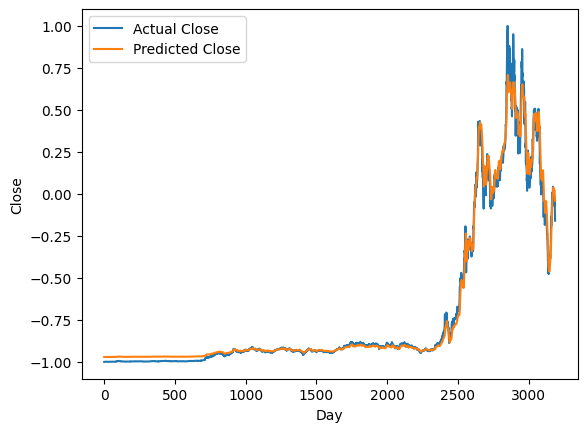

In [22]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [23]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  7.09124774,   7.06780537,   7.0515273 , ..., 204.59401248,
       201.48927861, 197.41246627])

In [24]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  1.15999972,   1.13666701,   1.20933348, ..., 187.71000653,
       182.00000043, 172.91999862])

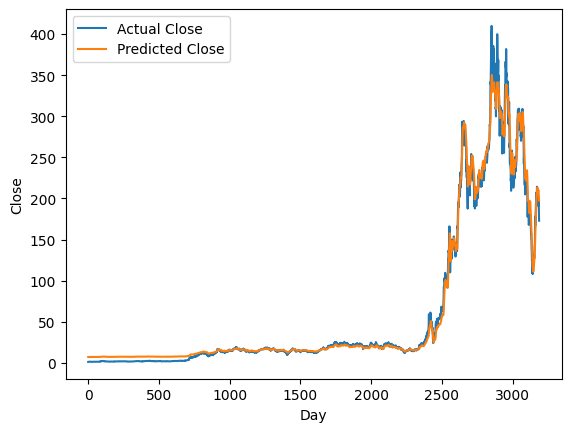

In [25]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [26]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([191.88259265, 187.14021018, 183.68992984, 183.41866119,
       183.830383  , 185.49432202, 186.38733124, 187.50438322,
       191.43343798, 193.98710867, 196.03798688, 197.13480093,
       197.89114626, 197.64440133, 198.07732971, 198.93138001,
       202.6083227 , 203.60176918, 203.3163151 , 200.88889691,
       197.97697164, 195.13356717, 193.4371238 , 191.20544146,
       190.75070948, 190.65973323, 191.22492092, 191.25447365,
       190.31449746, 185.18743901, 180.15786317, 175.2563309 ,
       171.01017974, 166.41180822, 164.34836812, 164.5469703 ,
       164.9859725 , 165.1293316 , 165.26116445, 165.41982079,
       167.46304124, 170.08572314, 171.97346123, 173.18153515,
       174.59867136, 174.7241258 , 173.96745149, 173.07614196,
       174.01255734, 176.05092239, 178.87474688, 183.42087871,
       186.9997631 , 188.90797671, 190.07820046, 192.49836906,
       196.50102847, 200.88892433, 205.47480401, 210.70991484,
       215.77726165, 220.46048991, 224.67451443, 230.09

In [27]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([173.44000126, 174.47999437, 183.25999419, 180.44999723,
       184.13000424, 180.13000556, 183.25000012, 197.58000183,
       191.14999429, 192.22000161, 190.41000317, 191.80999776,
       189.19000247, 193.88000514, 195.27999897, 207.46000681,
       194.7700041 , 192.58000157, 185.52000476, 185.05999703,
       184.50999388, 186.7899926 , 180.53999265, 185.89999439,
       185.00000059, 187.03999375, 184.30999813, 180.58999654,
       162.99000536, 165.08000089, 162.55000406, 160.66999683,
       153.75000238, 160.19000095, 164.30999708, 161.8300011 ,
       160.30999687, 160.61000191, 161.1999966 , 170.05999624,
       171.78999181, 169.14999313, 168.53999202, 172.08000278,
       167.97999479, 166.350007  , 166.52000376, 173.85999918,
       176.88999832, 180.13999963, 188.86999557, 185.77000439,
       182.89999423, 184.47000082, 193.16999854, 201.16000374,
       203.9299926 , 207.5200042 , 213.97000084, 217.61000033,
       221.30999703, 224.57000764, 234.86000086, 244.39

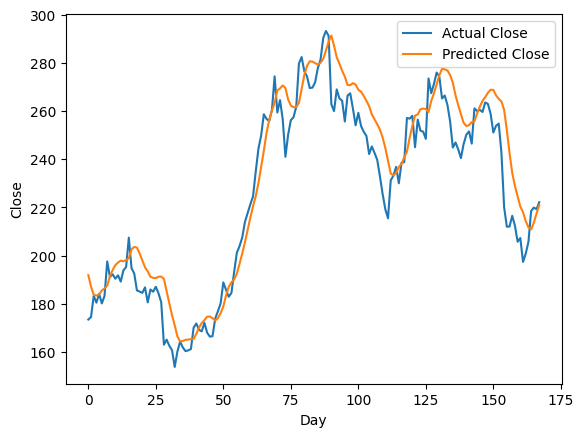

In [28]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()